In [1]:
import pandas as pd
import numpy as np
import joblib
import os
import benchmark_common as bcommon
import config as cfg
import benchmark_test as btest
import benchmark_train as btrain
import benchmark_evaluation as eva
from sklearn import metrics
import argparse
import tools.funclib as funclib
import tools.embedding_esm as esmebd
import time
import benchmark_evaluation as eva
from tqdm import tqdm
from pandarallel import pandarallel #  import pandaralle
pandarallel.initialize() 

%load_ext autoreload
%autoreload 2

INFO: Pandarallel will run on 104 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
from email import header
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Dense
from tools.Attention import Attention
from keras.layers import GRU, Bidirectional
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging
from sklearn.model_selection import train_test_split

In [4]:
EMBEDDING_METHOD = 'esm32'
print('step 1 loading task data')

data_task1_train = pd.read_feather(cfg.FILE_TASK1_TRAIN)
data_task2_train = pd.read_feather(cfg.FILE_TASK2_TRAIN)
data_task3_train = pd.read_feather(cfg.FILE_TASK3_TRAIN)

data_task1_test = pd.read_feather(cfg.FILE_TASK1_TEST)
data_task2_test = pd.read_feather(cfg.FILE_TASK2_TEST)
data_task3_test = pd.read_feather(cfg.FILE_TASK3_TEST)

print(f'step 2: Loading features, embdding method={EMBEDDING_METHOD}')
feature_df = bcommon.load_data_embedding(embedding_type=EMBEDDING_METHOD)

step 1 loading task data
step 2: Loading features, embdding method=esm32


In [109]:
print('step 3: train isEnzyme model')
task1_train_X, task1_train_Y = btrain.get_train_X_Y(traindata=data_task1_train, feature_bankfile=feature_df, task=1)
task1_test_X, task1_test_Y = btrain.get_train_X_Y(traindata=data_task1_test, feature_bankfile=feature_df, task=1)
t1_x_train, t1_x_vali, t1_y_train, t1_y_vali = train_test_split(task1_train_X,np.array(task1_train_Y).ravel(),test_size=cfg.VALIDATION_RATE,random_state=1)


t1_x_train = np.reshape(np.array(t1_x_train),(-1,1,1280))
t1_x_vali =np.reshape(np.array(t1_x_vali),(-1,1,1280))
task1_test_X =np.reshape(np.array(task1_test_X),(-1,1,1280))


t1_eval_set = [(t1_x_train, t1_y_train), (t1_x_vali, t1_y_vali), (task1_test_X, task1_test_Y)]

step 3: train isEnzyme model


In [128]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4155592230932309280
xla_global_id: -1
]


2022-10-10 13:38:24.350935: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [127]:
inputs = Input(shape=(1, 1280, ), name="input")
gru = Bidirectional(GRU(128, dropout=0.2, return_sequences=True), name="bi-gru")(inputs)
attention = Attention(32, name="attention")(gru)    
num_class = 1
output = Dense(num_class, activation='sigmoid', name="dense")(attention)
model = Model(inputs, output)

In [125]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


history = model.fit(
                        x=t1_x_train, 
                        y=t1_y_train, 
                        validation_data=(task1_test_X, task1_test_Y),
                        batch_size=128, 
                        epochs=5,
                        steps_per_epoch=5
                    )

Epoch 1/5
5/5 [==============================] - 4s 250ms/step - loss: 0.5529 - accuracy: 0.7094 - val_loss: 0.5584 - val_accuracy: 0.6559
Epoch 2/5
5/5 [==============================] - 0s 99ms/step - loss: 0.5674 - accuracy: 0.6812 - val_loss: 0.5281 - val_accuracy: 0.7418
Epoch 3/5
5/5 [==============================] - 0s 100ms/step - loss: 0.5511 - accuracy: 0.7312 - val_loss: 0.5266 - val_accuracy: 0.7538
Epoch 4/5
5/5 [==============================] - 0s 98ms/step - loss: 0.5753 - accuracy: 0.6781 - val_loss: 0.5759 - val_accuracy: 0.6214
Epoch 5/5
5/5 [==============================] - 0s 97ms/step - loss: 0.5448 - accuracy: 0.7219 - val_loss: 0.5242 - val_accuracy: 0.7642


In [62]:


# t1_y_train = np.reshape(np.array(t1_y_train),(-1,1))
# t1_y_vali = np.reshape(np.array(t1_y_vali),(-1,1))
# task1_test_Y = np.reshape(np.array(task1_test_Y),(-1,1))

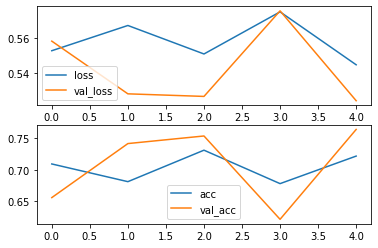

In [126]:
plt.subplot(2, 1, 1)
epochs = len(history.history['loss'])
plt.plot(range(epochs), history.history['loss'], label='loss')
plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(2, 1, 2)
epochs = len(history.history['accuracy'])
plt.plot(range(epochs), history.history['accuracy'], label='acc')
plt.plot(range(epochs), history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.savefig("loss_acc.png")

In [97]:
model.save(cfg.MODELDIR+'m_task1.h5')

In [107]:
import keras
from keras.models import load_model
load_model = load_model(cfg.MODELDIR+'m_task1.h5', custom_objects={"Attention": Attention},compile=False)
predicted = load_model.predict(task1_test_X)

res=pd.DataFrame({'groundtruth':task1_test_Y, 'pred_prob':predicted.flatten()})
res['predict']=res.pred_prob.apply(lambda x: 1 if x>=0.5 else 0)
res

332/332 [==============================] - 1s 2ms/step


,groundtruth,pred_prob,predict
0,0,4.202201e-02,0
1,0,2.109072e-04,0
2,0,1.140410e-01,0
3,0,3.089896e-02,0
4,0,4.774848e-01,0
...,...,...,...
10609,1,7.675893e-01,1
10610,1,9.958066e-01,1
10611,0,8.044339e-02,0
10612,0,1.114186e-07,0


In [118]:
print('baslineName', '\t\t', 'accuracy','\t', 'precision(PPV) \t NPV \t\t', 'recall','\t', 'f1', '\t\t', '\t confusion Matrix')
eva.caculateMetrix(groundtruth=res.groundtruth, predict=res.predict, baselineName='GRU', type='binary')

baslineName 		 accuracy 	 precision(PPV) 	 NPV 		 recall 	 f1 		 	 confusion Matrix
GRU 		0.827021 	0.831814 		0.822856 	0.803170 	0.817241 	 tp: 4105 fp: 830 fn: 1006 tn: 4673


In [75]:
predicted.flatten()

array([3.2466169e-02, 3.4216209e-05, 1.1147877e-01, ..., 1.7315976e-01,
       1.3262644e-06, 8.5364836e-01], dtype=float32)